# Preprocesamiento y EDA

Antes de seleccionar los modelos, se debe realizar un análisis de los datos con los que estamos trabajando. Así, se podrá elegir el mejor modelo para implementar.

El dataset con que estamos trabajando contiene señales EEG de sujetos de dos grupos, alcohólicos o controles. Se presentaron uno o dos estímulos (S1 o S1 y S2) en condiciones coincidentes (S1 = S2) o no coincidentes (S1 ̸= S2), con el objetivo de registrar la actividad cerebral mediante EEG durante el procesamiento visual y la toma de decisiones.

Sin embargo, la data se encuentra en un archivo .h5, que está diseñado para almacenar grandes cantidades de datos complejos. Por esta razón, no se puede trabajar de forma directa con el archivo.

Es por ello que se ha realizado un pipeline que extrae las caracteríticas más relevantes de nuestra base de datos (estamos trabajando con series de tiempo) y almacena dichos resultados en archivos .csv, que son más fáciles de manejar.

In [2]:
# Se importan las librerías necesarias para el procesamiento de datos y la extracción de características (tsfresh)
import os
import h5py
import pandas as pd
import numpy as np
from tsfresh import extract_features, select_features
from tsfresh.feature_extraction import EfficientFCParameters
from tsfresh.utilities.dataframe_functions import impute
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

Usaremos la librería h5py para abrir y leer archivos .h5:

In [3]:
train_file = "../train.h5"
test_file = "../test.h5"

with h5py.File(train_file, "r") as f:
    X_train = f["x"][:]   # señales EEG
    y_train = f["y"][:]   # etiquetas

with h5py.File(test_file, "r") as f:
    X_test = f["x"][:]    # señales EEG

# Exploración rápida
print(X_train.shape, X_train.dtype)
print(y_train.shape, y_train.dtype)
print(X_train[0,0,:5])  # primeras 5 muestras de EEG del primer sujeto
print(y_train[:5])       # primeras 5 etiquetas

(204, 1, 18530) float64
(204,) int64
[-0.00585938 -0.01141357 -0.01077271 -0.01055908 -0.0088501 ]
[0 1 0 0 0]


Se puede observar que la base de datos tiene registros de 204 personas. X_train contiene un atributo "y" que corresponde a las etiquetas, es decir, a los outputs (0 para control y 1 para alcoholicos). Este atributo fue guardado en y_train. Para cada persona, hay un total de 18530 registros de puntos que corresponden a su electroencefalograma. X_test contiene a otras 204 personas con sus respectivas muestras de EEG.

In [4]:
# Visualización de y_train 
y_train 
# Vemos que es un atributo binario (0 y 1)

array([0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1])

Se hizo un análisis de la distribución de los valores de y_train

In [5]:
# Análisis de distribución de clases
y, counts = np.unique(y_train, return_counts=True)
for label, count in zip(y, counts):
    print(f"Clase {label}: {count} muestras, proporción: {count/len(y_train):.2%}")

Clase 0: 149 muestras, proporción: 73.04%
Clase 1: 55 muestras, proporción: 26.96%


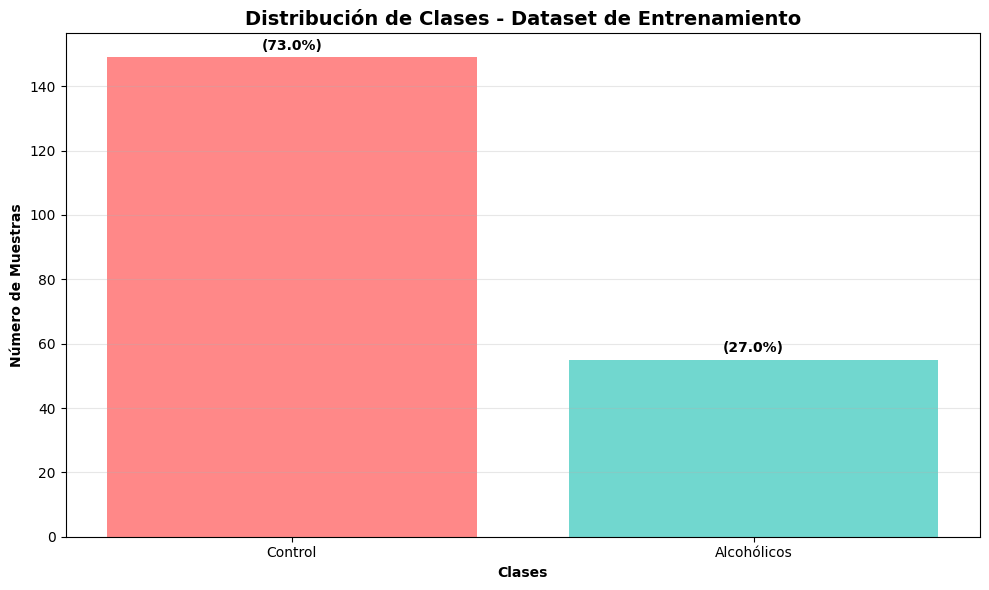

In [6]:
labels = ['Control', 'Alcohólicos']  # Clase 0: Control, Clase 1: Alcohólicos
# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, counts, color=['#ff6b6b', '#4ecdc4'], alpha=0.8)
# Añadir valores en las barras
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(counts)*0.01, 
             f'({count/len(y_train):.1%})', 
             ha='center', va='bottom', fontweight='bold')

plt.title('Distribución de Clases - Dataset de Entrenamiento', fontsize=14, fontweight='bold')
plt.ylabel('Número de Muestras', fontweight='bold')
plt.xlabel('Clases', fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

En el gráfico se puede observar como están distribuidas las clases en la base de datos. Lo primero que se observa inmediatamente es que existe un desbalance entre las clases, ya que la clase "control" equivale a casi 3/4 de los datos del dataset. Esto podría implicar que los modelos a implementar tengan un alto accuracy general, pero un rendimiento pobre en la clase minoritaria. Además, puede existir la posibilidad de que haya overfitting en la clase mayoritaria. 

Una posible solución para esto es utilizar Synthetic Minority Over-Sample technique o mejor conocido como SMOTE, que consiste en duplicar ejemplos de la clase minoritaria (como hace el oversampling tradicional). SMOTE crea ejemplos sintéticos nuevos combinando instancias existentes de la clase minoritaria. Por ende, sería conveniente utilizarlo para generar una distribución equitativa de los datos.

In [7]:
# Convertir a DataFrame ancho
x_h5_train_df = pd.DataFrame(X_train[:,0,:])
y_h5_train_df = pd.Series(y_train)

def parsear_times_series(dataset):
    parsed_data = []
    for id, series in enumerate(dataset):
        time_series_df = pd.DataFrame({
            'id': id,
            'time': np.arange(len(series)),
            'value': series
        })
        parsed_data.append(time_series_df)
    return pd.concat(parsed_data)

# Parsear train y test (primer canal [:,0,:])
long_train_df = parsear_times_series(X_train[:,0,:])
long_test_df = parsear_times_series(X_test[:,0,:])

y_train_series = pd.Series(y_train)

In [9]:
long_train_df.head()

id  time     value
0   0     0 -0.005859
1   0     1 -0.011414
2   0     2 -0.010773
3   0     3 -0.010559
4   0     4 -0.008850

In [10]:
y_train_series

0      0
1      1
2      0
3      0
4      0
      ..
199    0
200    0
201    0
202    0
203    1
Length: 204, dtype: int64

In [12]:
def procesar_en_bloques(long_df, y_labels=None, bloque_size=5, dataset_name="train"):
    os.makedirs("features_chunks", exist_ok=True)
    n_ids = long_df['id'].nunique()
    chunks_files = []

    # 🔹 Cambio a EfficientFCParameters
    fc_parameters = EfficientFCParameters()  # Más características balanceadas

    for start in range(0, n_ids, bloque_size):
        end = min(start + bloque_size, n_ids)
        bloque_ids = list(range(start, end))
        bloque_df = long_df[long_df['id'].isin(bloque_ids)]

        # Extraer features
        features_bloque = extract_features(
            bloque_df,
            column_id='id',
            column_sort='time',
            default_fc_parameters=fc_parameters
        )
        impute(features_bloque)
        # Guardar CSV temporal
        file_path = f"features_chunks/{dataset_name}_features_{start}_{end}.csv"
        features_bloque.to_csv(file_path)
        chunks_files.append(file_path)
        print(f"Bloque {start}-{end} procesado y guardado en {file_path}")

    # Combinar todos los CSVs
    features_final = pd.concat([pd.read_csv(f, index_col=0) for f in chunks_files])

    # Selección de features si hay etiquetas
    if y_labels is not None:
        features_final = select_features(features_final, y_labels)

    # 🔹 Guardar el archivo combinado
    final_file = f"features_chunks/{dataset_name}_features_final.csv"
    features_final.to_csv(final_file)
    print(f"Features combinadas guardadas en {final_file}")

    return features_final

In [14]:
X_train_features = procesar_en_bloques(long_train_df, y_labels=y_train_series, bloque_size=5, dataset_name="train")

Feature Extraction: 100%|██████████| 5/5 [00:11<00:00,  2.28s/it]
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Bloque 0-5 procesado y guardado en features_chunks/train_features_0_5.csv


Feature Extraction: 100%|██████████| 5/5 [00:10<00:00,  2.12s/it]
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Bloque 5-10 procesado y guardado en features_chunks/train_features_5_10.csv


Feature Extraction: 100%|██████████| 5/5 [00:10<00:00,  2.11s/it]
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Bloque 10-15 procesado y guardado en features_chunks/train_features_10_15.csv


Feature Extraction: 100%|██████████| 5/5 [00:11<00:00,  2.25s/it]
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Bloque 15-20 procesado y guardado en features_chunks/train_features_15_20.csv


Feature Extraction: 100%|██████████| 5/5 [00:10<00:00,  2.10s/it]
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Bloque 20-25 procesado y guardado en features_chunks/train_features_20_25.csv


Feature Extraction: 100%|██████████| 5/5 [00:09<00:00,  1.98s/it]
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Bloque 25-30 procesado y guardado en features_chunks/train_features_25_30.csv


Feature Extraction: 100%|██████████| 5/5 [00:12<00:00,  2.44s/it]
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Bloque 30-35 procesado y guardado en features_chunks/train_features_30_35.csv


Feature Extraction: 100%|██████████| 5/5 [00:10<00:00,  2.07s/it]
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Bloque 35-40 procesado y guardado en features_chunks/train_features_35_40.csv


Feature Extraction: 100%|██████████| 5/5 [00:11<00:00,  2.22s/it]
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Bloque 40-45 procesado y guardado en features_chunks/train_features_40_45.csv


Feature Extraction: 100%|██████████| 5/5 [00:12<00:00,  2.50s/it]
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Bloque 45-50 procesado y guardado en features_chunks/train_features_45_50.csv


Feature Extraction: 100%|██████████| 5/5 [00:12<00:00,  2.59s/it]
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Bloque 50-55 procesado y guardado en features_chunks/train_features_50_55.csv


Feature Extraction: 100%|██████████| 5/5 [00:11<00:00,  2.36s/it]
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Bloque 55-60 procesado y guardado en features_chunks/train_features_55_60.csv


Feature Extraction: 100%|██████████| 5/5 [00:12<00:00,  2.52s/it]
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Bloque 60-65 procesado y guardado en features_chunks/train_features_60_65.csv


Feature Extraction: 100%|██████████| 5/5 [00:12<00:00,  2.41s/it]
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Bloque 65-70 procesado y guardado en features_chunks/train_features_65_70.csv


Feature Extraction: 100%|██████████| 5/5 [00:13<00:00,  2.64s/it]
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Bloque 70-75 procesado y guardado en features_chunks/train_features_70_75.csv


Feature Extraction: 100%|██████████| 5/5 [00:10<00:00,  2.15s/it]
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Bloque 75-80 procesado y guardado en features_chunks/train_features_75_80.csv


Feature Extraction: 100%|██████████| 5/5 [00:11<00:00,  2.37s/it]
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Bloque 80-85 procesado y guardado en features_chunks/train_features_80_85.csv


Feature Extraction: 100%|██████████| 5/5 [00:10<00:00,  2.02s/it]
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Bloque 85-90 procesado y guardado en features_chunks/train_features_85_90.csv


Feature Extraction: 100%|██████████| 5/5 [00:13<00:00,  2.70s/it]
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Bloque 90-95 procesado y guardado en features_chunks/train_features_90_95.csv


Feature Extraction: 100%|██████████| 5/5 [00:14<00:00,  2.83s/it]
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Bloque 95-100 procesado y guardado en features_chunks/train_features_95_100.csv


Feature Extraction: 100%|██████████| 5/5 [00:13<00:00,  2.67s/it]
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Bloque 100-105 procesado y guardado en features_chunks/train_features_100_105.csv


Feature Extraction: 100%|██████████| 5/5 [00:11<00:00,  2.23s/it]
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Bloque 105-110 procesado y guardado en features_chunks/train_features_105_110.csv


Feature Extraction: 100%|██████████| 5/5 [00:10<00:00,  2.04s/it]
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Bloque 110-115 procesado y guardado en features_chunks/train_features_110_115.csv


Feature Extraction: 100%|██████████| 5/5 [00:11<00:00,  2.23s/it]
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Bloque 115-120 procesado y guardado en features_chunks/train_features_115_120.csv


Feature Extraction: 100%|██████████| 5/5 [00:10<00:00,  2.10s/it]
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Bloque 120-125 procesado y guardado en features_chunks/train_features_120_125.csv


Feature Extraction: 100%|██████████| 5/5 [00:12<00:00,  2.40s/it]
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Bloque 125-130 procesado y guardado en features_chunks/train_features_125_130.csv


Feature Extraction: 100%|██████████| 5/5 [00:11<00:00,  2.33s/it]
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Bloque 130-135 procesado y guardado en features_chunks/train_features_130_135.csv


Feature Extraction: 100%|██████████| 5/5 [00:13<00:00,  2.63s/it]
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Bloque 135-140 procesado y guardado en features_chunks/train_features_135_140.csv


Feature Extraction: 100%|██████████| 5/5 [00:11<00:00,  2.37s/it]
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Bloque 140-145 procesado y guardado en features_chunks/train_features_140_145.csv


Feature Extraction: 100%|██████████| 5/5 [00:11<00:00,  2.20s/it]
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Bloque 145-150 procesado y guardado en features_chunks/train_features_145_150.csv


Feature Extraction: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Bloque 150-155 procesado y guardado en features_chunks/train_features_150_155.csv


Feature Extraction: 100%|██████████| 5/5 [00:10<00:00,  2.14s/it]
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Bloque 155-160 procesado y guardado en features_chunks/train_features_155_160.csv


Feature Extraction: 100%|██████████| 5/5 [00:12<00:00,  2.56s/it]
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Bloque 160-165 procesado y guardado en features_chunks/train_features_160_165.csv


Feature Extraction: 100%|██████████| 5/5 [00:11<00:00,  2.33s/it]
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Bloque 165-170 procesado y guardado en features_chunks/train_features_165_170.csv


Feature Extraction: 100%|██████████| 5/5 [00:10<00:00,  2.15s/it]
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Bloque 170-175 procesado y guardado en features_chunks/train_features_170_175.csv


Feature Extraction: 100%|██████████| 5/5 [00:10<00:00,  2.08s/it]
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Bloque 175-180 procesado y guardado en features_chunks/train_features_175_180.csv


Feature Extraction: 100%|██████████| 5/5 [00:12<00:00,  2.41s/it]
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Bloque 180-185 procesado y guardado en features_chunks/train_features_180_185.csv


Feature Extraction: 100%|██████████| 5/5 [00:12<00:00,  2.51s/it]
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Bloque 185-190 procesado y guardado en features_chunks/train_features_185_190.csv


Feature Extraction: 100%|██████████| 5/5 [00:11<00:00,  2.23s/it]
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Bloque 190-195 procesado y guardado en features_chunks/train_features_190_195.csv


Feature Extraction: 100%|██████████| 5/5 [00:10<00:00,  2.12s/it]
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Bloque 195-200 procesado y guardado en features_chunks/train_features_195_200.csv


Feature Extraction: 100%|██████████| 4/4 [00:10<00:00,  2.57s/it]
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Bloque 200-204 procesado y guardado en features_chunks/train_features_200_204.csv
Features combinadas guardadas en features_chunks/train_features_final.csv


In [16]:
X_test_features = procesar_en_bloques(long_test_df, y_labels=None, bloque_size=5, dataset_name="test")

Feature Extraction: 100%|██████████| 5/5 [00:09<00:00,  1.93s/it]
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Bloque 0-5 procesado y guardado en features_chunks/test_features_0_5.csv


Feature Extraction: 100%|██████████| 5/5 [00:08<00:00,  1.76s/it]
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Bloque 5-10 procesado y guardado en features_chunks/test_features_5_10.csv


Feature Extraction: 100%|██████████| 5/5 [00:10<00:00,  2.11s/it]
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Bloque 10-15 procesado y guardado en features_chunks/test_features_10_15.csv


Feature Extraction: 100%|██████████| 5/5 [00:10<00:00,  2.12s/it]
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Bloque 15-20 procesado y guardado en features_chunks/test_features_15_20.csv


Feature Extraction: 100%|██████████| 5/5 [00:09<00:00,  1.96s/it]
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Bloque 20-25 procesado y guardado en features_chunks/test_features_20_25.csv


Feature Extraction: 100%|██████████| 5/5 [00:09<00:00,  1.97s/it]
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Bloque 25-30 procesado y guardado en features_chunks/test_features_25_30.csv


Feature Extraction: 100%|██████████| 5/5 [00:10<00:00,  2.12s/it]
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Bloque 30-35 procesado y guardado en features_chunks/test_features_30_35.csv


Feature Extraction: 100%|██████████| 5/5 [00:13<00:00,  2.74s/it]
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Bloque 35-40 procesado y guardado en features_chunks/test_features_35_40.csv


Feature Extraction: 100%|██████████| 5/5 [00:12<00:00,  2.46s/it]
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Bloque 40-45 procesado y guardado en features_chunks/test_features_40_45.csv


Feature Extraction: 100%|██████████| 5/5 [00:13<00:00,  2.64s/it]
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Bloque 45-50 procesado y guardado en features_chunks/test_features_45_50.csv


Feature Extraction: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Bloque 50-55 procesado y guardado en features_chunks/test_features_50_55.csv


Feature Extraction: 100%|██████████| 5/5 [00:12<00:00,  2.54s/it]
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Bloque 55-60 procesado y guardado en features_chunks/test_features_55_60.csv


Feature Extraction: 100%|██████████| 5/5 [00:10<00:00,  2.12s/it]
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Bloque 60-65 procesado y guardado en features_chunks/test_features_60_65.csv


Feature Extraction: 100%|██████████| 5/5 [00:12<00:00,  2.52s/it]
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Bloque 65-70 procesado y guardado en features_chunks/test_features_65_70.csv


Feature Extraction: 100%|██████████| 5/5 [00:13<00:00,  2.66s/it]
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Bloque 70-75 procesado y guardado en features_chunks/test_features_70_75.csv


Feature Extraction: 100%|██████████| 5/5 [00:12<00:00,  2.41s/it]
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Bloque 75-80 procesado y guardado en features_chunks/test_features_75_80.csv


Feature Extraction: 100%|██████████| 5/5 [00:13<00:00,  2.62s/it]
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Bloque 80-85 procesado y guardado en features_chunks/test_features_80_85.csv


Feature Extraction: 100%|██████████| 5/5 [00:12<00:00,  2.50s/it]
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Bloque 85-90 procesado y guardado en features_chunks/test_features_85_90.csv


Feature Extraction: 100%|██████████| 5/5 [00:13<00:00,  2.65s/it]
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Bloque 90-95 procesado y guardado en features_chunks/test_features_90_95.csv


Feature Extraction: 100%|██████████| 5/5 [00:14<00:00,  2.85s/it]
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Bloque 95-100 procesado y guardado en features_chunks/test_features_95_100.csv


Feature Extraction: 100%|██████████| 5/5 [00:13<00:00,  2.62s/it]
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Bloque 100-105 procesado y guardado en features_chunks/test_features_100_105.csv


Feature Extraction: 100%|██████████| 5/5 [00:11<00:00,  2.32s/it]
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Bloque 105-110 procesado y guardado en features_chunks/test_features_105_110.csv


Feature Extraction: 100%|██████████| 5/5 [00:12<00:00,  2.43s/it]
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Bloque 110-115 procesado y guardado en features_chunks/test_features_110_115.csv


Feature Extraction: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Bloque 115-120 procesado y guardado en features_chunks/test_features_115_120.csv


Feature Extraction: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Bloque 120-125 procesado y guardado en features_chunks/test_features_120_125.csv


Feature Extraction: 100%|██████████| 5/5 [00:11<00:00,  2.34s/it]
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Bloque 125-130 procesado y guardado en features_chunks/test_features_125_130.csv


Feature Extraction: 100%|██████████| 5/5 [00:10<00:00,  2.19s/it]
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Bloque 130-135 procesado y guardado en features_chunks/test_features_130_135.csv


Feature Extraction: 100%|██████████| 5/5 [00:11<00:00,  2.21s/it]
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Bloque 135-140 procesado y guardado en features_chunks/test_features_135_140.csv


Feature Extraction: 100%|██████████| 5/5 [00:12<00:00,  2.53s/it]
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Bloque 140-145 procesado y guardado en features_chunks/test_features_140_145.csv


Feature Extraction: 100%|██████████| 5/5 [00:12<00:00,  2.59s/it]
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Bloque 145-150 procesado y guardado en features_chunks/test_features_145_150.csv


Feature Extraction: 100%|██████████| 5/5 [00:12<00:00,  2.56s/it]
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Bloque 150-155 procesado y guardado en features_chunks/test_features_150_155.csv


Feature Extraction: 100%|██████████| 5/5 [00:12<00:00,  2.47s/it]
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Bloque 155-160 procesado y guardado en features_chunks/test_features_155_160.csv


Feature Extraction: 100%|██████████| 5/5 [00:11<00:00,  2.22s/it]
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Bloque 160-165 procesado y guardado en features_chunks/test_features_160_165.csv


Feature Extraction: 100%|██████████| 5/5 [00:12<00:00,  2.50s/it]
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Bloque 165-170 procesado y guardado en features_chunks/test_features_165_170.csv


Feature Extraction: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Bloque 170-175 procesado y guardado en features_chunks/test_features_170_175.csv


Feature Extraction: 100%|██████████| 5/5 [00:13<00:00,  2.61s/it]
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Bloque 175-180 procesado y guardado en features_chunks/test_features_175_180.csv


Feature Extraction: 100%|██████████| 5/5 [00:11<00:00,  2.34s/it]
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Bloque 180-185 procesado y guardado en features_chunks/test_features_180_185.csv


Feature Extraction: 100%|██████████| 5/5 [00:12<00:00,  2.48s/it]
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Bloque 185-190 procesado y guardado en features_chunks/test_features_185_190.csv


Feature Extraction: 100%|██████████| 5/5 [00:11<00:00,  2.24s/it]
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Bloque 190-195 procesado y guardado en features_chunks/test_features_190_195.csv


Feature Extraction: 100%|██████████| 5/5 [00:10<00:00,  2.05s/it]
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Bloque 195-200 procesado y guardado en features_chunks/test_features_195_200.csv


Feature Extraction: 100%|██████████| 5/5 [00:11<00:00,  2.21s/it]
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Bloque 200-205 procesado y guardado en features_chunks/test_features_200_205.csv
Features combinadas guardadas en features_chunks/test_features_final.csv


In [17]:
X_train_features.shape 


(204, 208)

In [18]:
X_test_features.shape

(205, 777)

In [19]:
# Alinear columnas (usar solo columnas de train en test)
X_test_features = X_test_features[X_train_features.columns]

In [20]:
X_test_features.shape

(205, 208)

In [30]:
from pandas import read_csv
X_train_features = read_csv("../data/final_features/train_features_final.csv", index_col=0)
X_test_features = read_csv("../data/final_features/test_features_final.csv", index_col=0)

In [31]:
X_train_features

value__permutation_entropy__dimension_3__tau_1  \
0                                          1.222197   
1                                          1.148054   
2                                          1.649418   
3                                          1.663552   
4                                          1.479723   
..                                              ...   
199                                        1.752684   
200                                        1.721757   
201                                        1.210007   
202                                        1.604492   
203                                        1.110314   

     value__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.2  \
0                                             0.000040                    
1                                             0.000006                    
2                                             0.000006                    
3                                             0.000002                    
4                                            -0.000054                    
..                                                 ...                    
199                                           0.000002                    
200                                           0.000005                    
201                                          -0.000083                    
202                                          -0.000009                    
203                                          -0.000199                    

     value__number_peaks__n_1  value__number_cwt_peaks__n_1  \
0                      1351.0                         873.0   
1                      1098.0                         666.0   
2                      3688.0                        1041.0   
3                      3824.0                        1248.0   
4                      2564.0                         848.0   
..                        ...                           ...   
199                    4903.0                        1280.0   
200                    4473.0                         915.0   
201                    1314.0                         762.0   
202                    3258.0                         934.0   
203                     979.0                         664.0   

     value__permutation_entropy__dimension_4__tau_1  \
0                                          1.779523   
1                                          1.645622   
2                                          2.545695   
3                                          2.610122   
4                                          2.184056   
..                                              ...   
199                                        2.775545   
200                                        2.729553   
201                                        1.724411   
202                                        2.468804   
203                                        1.567078   

     value__ar_coefficient__coeff_1__k_10  \
0                                1.099913   
1                                2.443051   
2                                1.211280   
3                                1.117250   
4                                0.861699   
..                                    ...   
199                              1.059679   
200                              1.359885   
201                              1.744408   
202                              0.951695   
203                              2.176296   

     value__fft_coefficient__attr_"abs"__coeff_47  \
0                                        0.397931   
1                                        4.304379   
2                                        0.771397   
3                                        0.945263   
4                                        3.127330   
..                                            ...   
199                                      0.150297   
200                                      1.368622   
201    

TOP 20 CARACTERÍSTICAS POR ANOVA F-TEST
Feature                        F-Score    P-Value    -log10(P) 
------------------------------------------------------------
value__permutation_entropy__dimension_3__tau_1 37.62      0.0000     8.35      
value__permutation_entropy__dimension_4__tau_1 32.56      0.0000     7.39      
value__partial_autocorrelation__lag_3 32.14      0.0000     7.31      
value__ar_coefficient__coeff_2__k_10 30.09      0.0000     6.91      
value__permutation_entropy__dimension_5__tau_1 30.05      0.0000     6.90      
value__permutation_entropy__dimension_6__tau_1 28.51      0.0000     6.60      
value__number_cwt_peaks__n_1   27.44      0.0000     6.39      
value__number_peaks__n_1       27.05      0.0000     6.32      
value__permutation_entropy__dimension_7__tau_1 26.86      0.0000     6.28      
value__ar_coefficient__coeff_1__k_10 24.36      0.0000     5.78      
value__fft_aggregated__aggtype_"kurtosis" 19.83      0.0000     4.85      
value__maximum       

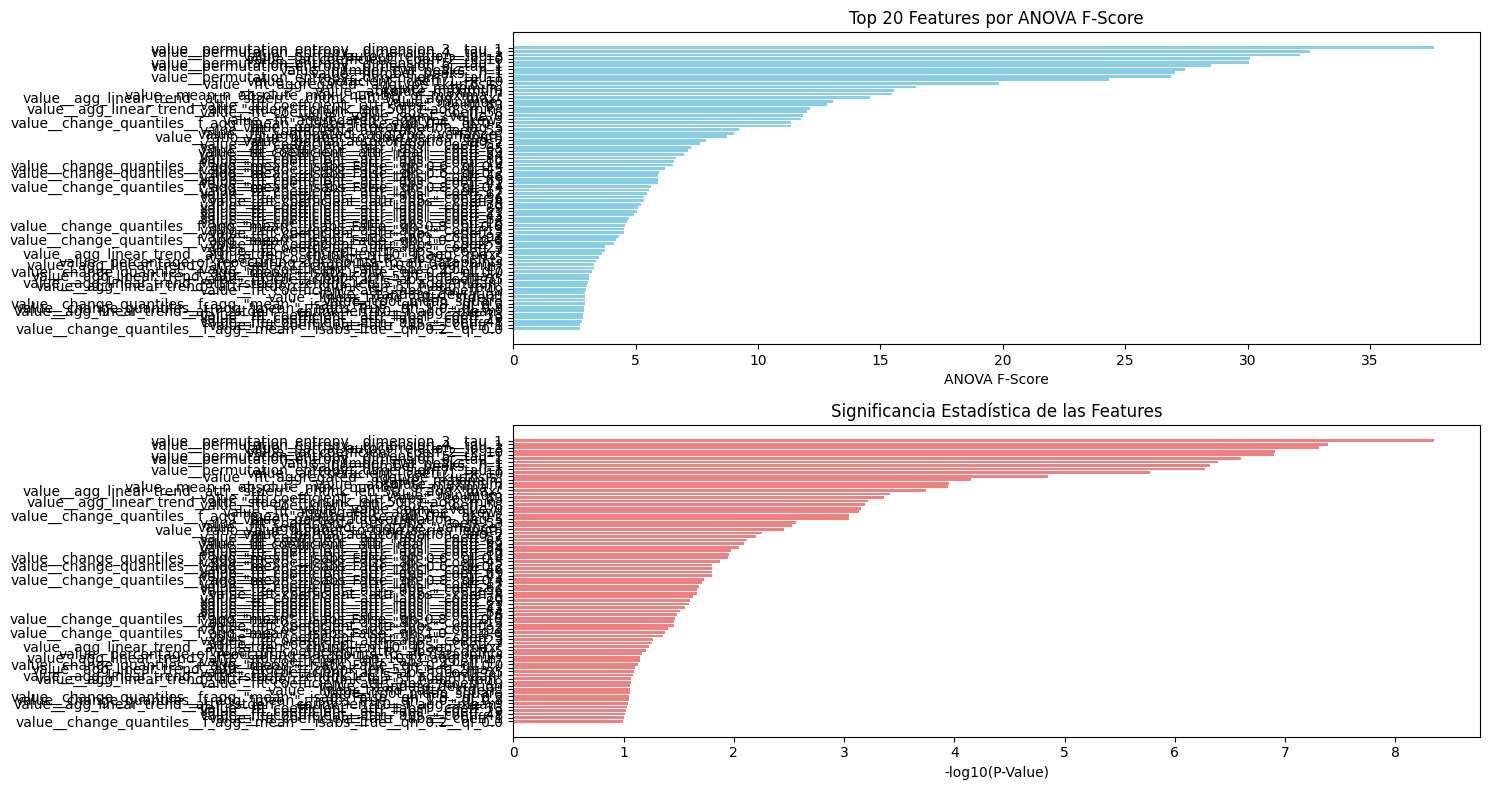

In [99]:
# Aplicar ANOVA y obtener resultados detallados
f_scores, p_values = f_classif(X_train_features, y_train_series)

# Crear DataFrame con resultados
anova_results = pd.DataFrame({
    'Feature': X_train_features.columns,
    'F_Score': f_scores,
    'P_Value': p_values,
    'neg_log_pvalue': -np.log10(p_values)  # Para visualización
})

# Ordenar por F-score
anova_results_sorted = anova_results.sort_values('F_Score', ascending=False)

# Seleccionar top 20
top_20 = anova_results_sorted.head(80)

print("="*60)
print("TOP 20 CARACTERÍSTICAS POR ANOVA F-TEST")
print("="*60)
print(f"{'Feature':<30} {'F-Score':<10} {'P-Value':<10} {'-log10(P)':<10}")
print("-"*60)

for idx, row in top_20.iterrows():
    print(f"{row['Feature']:<30} {row['F_Score']:<10.2f} {row['P_Value']:<10.4f} {row['neg_log_pvalue']:<10.2f}")

# 6. Visualización de resultados
plt.figure(figsize=(15, 8))

# Gráfico 1: Top 20 features por F-score
plt.subplot(2, 1, 1)
plt.barh(top_20['Feature'], top_20['F_Score'], color='skyblue')
plt.xlabel('ANOVA F-Score')
plt.title('Top 20 Features por ANOVA F-Score')
plt.gca().invert_yaxis()  # Mejor visualización

# Gráfico 2: Significancia estadística (-log10 p-value)
plt.subplot(2, 1, 2)
plt.barh(top_20['Feature'], top_20['neg_log_pvalue'], color='lightcoral')
plt.xlabel('-log10(P-Value)')
plt.title('Significancia Estadística de las Features')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

In [100]:

X_train_top20 = X_train_features[top_20['Feature']]
X_test_top20 = X_test_features[top_20['Feature']]

In [101]:
# A X_train_top20 agregale el target como columna 
X_train_top20 = X_train_top20.copy()  # Evitar SettingWithCopyWarning
X_train_top20['target'] = y_train_series

In [102]:
# Guarda los datasets en CSV
X_train_top20.to_csv("X_train_top20_features.csv", index=False)
X_test_top20.to_csv("X_test_top20_features.csv", index=False)

In [103]:
X_train_top20

value__permutation_entropy__dimension_3__tau_1  \
0                                          1.222197   
1                                          1.148054   
2                                          1.649418   
3                                          1.663552   
4                                          1.479723   
..                                              ...   
199                                        1.752684   
200                                        1.721757   
201                                        1.210007   
202                                        1.604492   
203                                        1.110314   

     value__permutation_entropy__dimension_4__tau_1  \
0                                          1.779523   
1                                          1.645622   
2                                          2.545695   
3                                          2.610122   
4                                          2.184056   
..                                              ...   
199                                        2.775545   
200                                        2.729553   
201                                        1.724411   
202                                        2.468804   
203                                        1.567078   

     value__partial_autocorrelation__lag_3  \
0                                -0.364176   
1                                 0.503543   
2                                -0.654519   
3                                -0.500066   
4                                -0.574134   
..                                     ...   
199                              -0.565589   
200                              -0.566730   
201                              -0.157084   
202                              -0.339121   
203                               0.387279   

     value__ar_coefficient__coeff_2__k_10  \
0                                0.039579   
1                               -2.548149   
2                                0.595491   
3                                0.336535   
4                                0.597538   
..                                    ...   
199                              0.480745   
200                              0.356997   
201                             -0.622847   
202                              0.339161   
203                             -1.373707   

     value__permutation_entropy__dimension_5__tau_1  \
0                                          2.375477   
1                                          2.196140   
2                                          3.470808   
3                                          3.569896   
4                                          2.926665   
..                                              ...   
199                                        3.782724   
200                                        3.774043   
201                                        2.278402   
202                                        3.394110   
203                                        2.064454   

     value__permutation_entropy__dimension_6__tau_1  \
0                                          3.002084   
1                                          2.777400   
2                                          4.431796   
3                                          4.564650   
4                                          3.690862   
..                                              ...   
199                                        4.820104   
200                                        4.848910   
201                                        2.854192   
202                                        4.373966   
203                                        2.589427   

     value__number_cwt_peaks__n_1  value__number_peaks__n_1  \
0                           873.0                    1351.0   
1                           666.0                    1098.0   
2                          1041.0                    3688.0   
3              

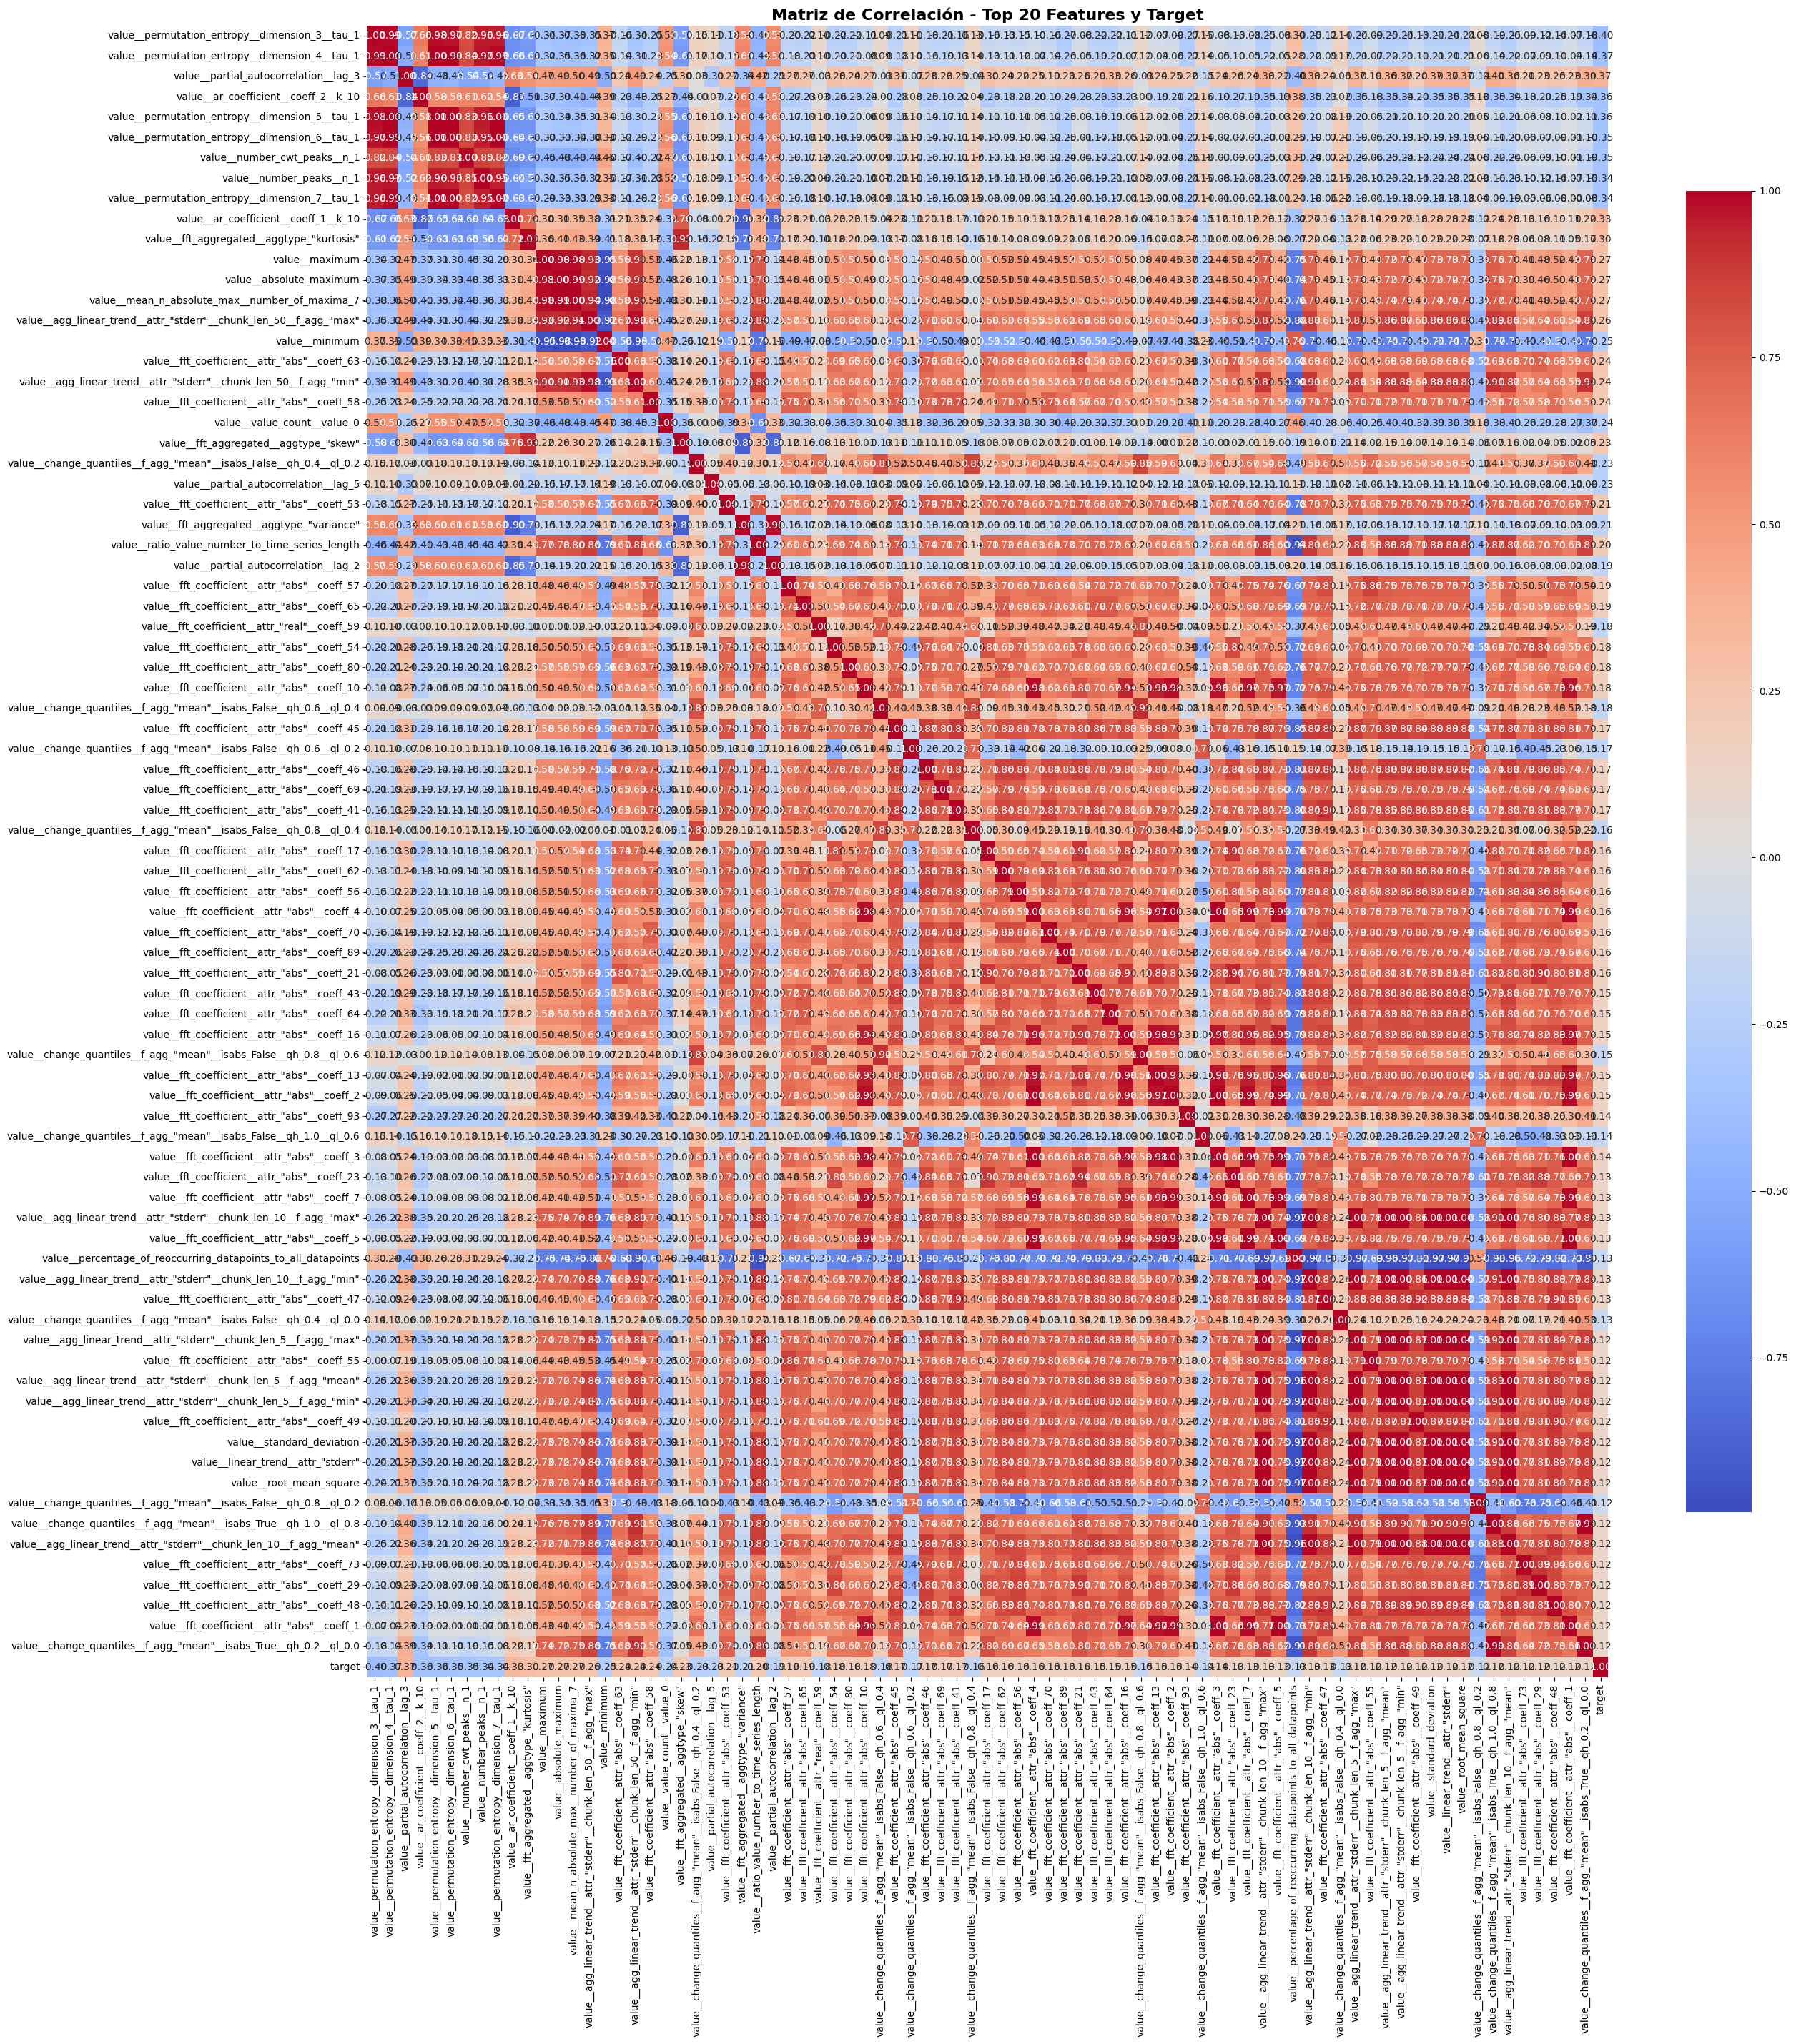

In [ ]:
# Creame una matriz de correlación de las top 20 features y la target con seaborn
corr_matrix = X_train_top20.corr()
plt.figure(figsize=(28, 30))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={"shrink": .8})
plt.title('Matriz de Correlación - Top 60 Features y Target', fontsize=16, fontweight='bold')
plt.show()

In [153]:
x_train_final = X_train_top20.copy()
x_test_final = X_test_top20.copy()

# Grupos de columnas a eliminar:
groups_to_drop = [
    # Grupo 1: Features de permutation_entropy dimension 4 a 7
    # Motivo: Solo se conserva dimension_3; las demás son redundantes y no aportan información adicional relevante
    [
        'value__permutation_entropy__dimension_4__tau_1',
        'value__permutation_entropy__dimension_5__tau_1',
        'value__permutation_entropy__dimension_6__tau_1',
        'value__permutation_entropy__dimension_7__tau_1'
    ],
    
    # Grupo 2: Coeficiente AR adicional
    # Motivo: Se conserva solo coeff_2 porque es más representativo de la dependencia temporal; coeff_1 es redundante
    [
        'value__ar_coefficient__coeff_1__k_10',
    ],

    # Grupo 3: Variables de picos redundantes
    # Motivo: 'value__number_peaks__n_1' y 'value__mean_n_absolute_max__number_of_maxima_7' aportan información similar a 'value__number_cwt_peaks__n_1' y 'value__absolute_maximum'
    [
        'value__number_peaks__n_1',
        'value__mean_n_absolute_max__number_of_maxima_7'
    ],

    # Grupo 4: Máximos y mínimos redundantes
    # Motivo: Se conserva solo 'value__absolute_maximum'; las demás variables de máximos/mínimos aportan información repetida
    [
        'value__maximum',
        'minimum',
        'agg_linear_trend__stderr__min',
        'value__minimum', 
        'value__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"max"',
        'value__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"min"',
    ],

    # Grupo 5: Partial autocorrelation redundante
    # Motivo: Se conserva lag_3 porque es más relevante; lags 2 y 5 son menos informativos
    [
        'value__partial_autocorrelation__lag_2',
        'value__partial_autocorrelation__lag_5',
    ],

    # Grupo 6: FFT coefficients redundantes
    # Motivo: Se eliminan muchos coeficientes de FFT cuya información ya está capturada por los coeficientes más relevantes seleccionados
    [
        'value__fft_coefficient__attr_"abs"__coeff_1',
        'value__fft_coefficient__attr_"abs"__coeff_2',
        'value__fft_coefficient__attr_"abs"__coeff_3',
        'value__fft_coefficient__attr_"abs"__coeff_4',
        'value__fft_coefficient__attr_"abs"__coeff_5',
        'value__fft_coefficient__attr_"abs"__coeff_7',
        'value__fft_coefficient__attr_"abs"__coeff_10',
        'value__fft_coefficient__attr_"abs"__coeff_13',
        'value__fft_coefficient__attr_"abs"__coeff_16',
        'value__fft_coefficient__attr_"abs"__coeff_17',
        'value__fft_coefficient__attr_"abs"__coeff_21',
        'value__fft_coefficient__attr_"abs"__coeff_23',
        'value__fft_coefficient__attr_"abs"__coeff_29',
        'value__fft_coefficient__attr_"abs"__coeff_41',
        'value__fft_coefficient__attr_"abs"__coeff_43',
        'value__fft_coefficient__attr_"abs"__coeff_45',
        'value__fft_coefficient__attr_"abs"__coeff_46',
        'value__fft_coefficient__attr_"abs"__coeff_47',
        'value__fft_coefficient__attr_"abs"__coeff_48',
        'value__fft_coefficient__attr_"abs"__coeff_49',
        'value__fft_coefficient__attr_"abs"__coeff_53',
        'value__fft_coefficient__attr_"abs"__coeff_54',
        'value__fft_coefficient__attr_"abs"__coeff_55',
        'value__fft_coefficient__attr_"abs"__coeff_56',
        'value__fft_coefficient__attr_"abs"__coeff_57',
        'value__fft_coefficient__attr_"abs"__coeff_58',
        'value__fft_coefficient__attr_"abs"__coeff_62',
        'value__fft_coefficient__attr_"abs"__coeff_64',
        'value__fft_coefficient__attr_"abs"__coeff_65',
        'value__fft_coefficient__attr_"abs"__coeff_69',
        'value__fft_coefficient__attr_"abs"__coeff_70',
        'value__fft_coefficient__attr_"abs"__coeff_73',
        'value__fft_coefficient__attr_"abs"__coeff_80',
        'value__fft_coefficient__attr_"abs"__coeff_89',
        'value__fft_coefficient__attr_"abs"__coeff_93',
    ],

    # Grupo 8: FFT aggregated stats redundantes
    # Motivo: Solo se conserva 'kurtosis'; skew y variance se eliminan por redundancia
    [
        'value__fft_aggregated__aggtype_"skew"',
        'value__fft_aggregated__aggtype_"variance"',
    ],

    # Grupo 9: Partial autocorrelation repetido
    # Motivo: Igual que el grupo 5; ya se eliminó lag_2 y lag_5
    [
        'value__partial_autocorrelation__lag_2',
        'value__partial_autocorrelation__lag_5',
    ],

    #Grupo 10: Change quantiles redundantes
    # Motivo: Se eliminan cuantiles intermedios que aportan información similar a los más extremos o representativos
    [
        'value__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.4',
        'value__change_quantiles__f_agg_"mean"__isabs_False__qh_0.6__ql_0.2',
        'value__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.4',
    ],

    #Grupo 11: Variables de tendencia y dispersión redundantes
    # Motivo: Se eliminan varias métricas de tendencia y RMS porque 'standard_deviation' ya captura la dispersión general y es suficiente
    [
        'value__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max"',
        'value__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min"',
        'value__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min"',
        'value__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min"',
        'value__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean"',
        'value__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max"',
        'value__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean"',
        'value__linear_trend__attr_"stderr"',
        'value__root_mean_square',
    ],

    #Grupo 12: Change quantiles duplicadas
    # Motivo: Se conservan solo las más representativas; las demás aportan información redundante
    [
        'value__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.2',
        'value__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.6',
        'value__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.6',
        'value__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.0',
        'value__change_quantiles__f_agg_"mean"__isabs_True__qh_0.2__ql_0.0',
        'value__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8',
    ]
]

# Iterar y eliminar columnas de cada grupo
for group in groups_to_drop:
    x_train_final = x_train_final.drop(columns=group, errors='ignore')

# Verificar
print(x_train_final.shape)



(204, 14)


In [150]:
# Mostrar todas las columnas restantes
print("Columnas finales en x_train_final:")
for col in x_train_final.columns:
    print(col)


Columnas finales en x_train_final:
value__permutation_entropy__dimension_3__tau_1
value__partial_autocorrelation__lag_3
value__ar_coefficient__coeff_2__k_10
value__number_cwt_peaks__n_1
value__fft_aggregated__aggtype_"kurtosis"
value__absolute_maximum
value__fft_coefficient__attr_"abs"__coeff_63
value__value_count__value_0
value__ratio_value_number_to_time_series_length
value__fft_coefficient__attr_"real"__coeff_59
value__percentage_of_reoccurring_datapoints_to_all_datapoints
value__standard_deviation
value__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.2
target


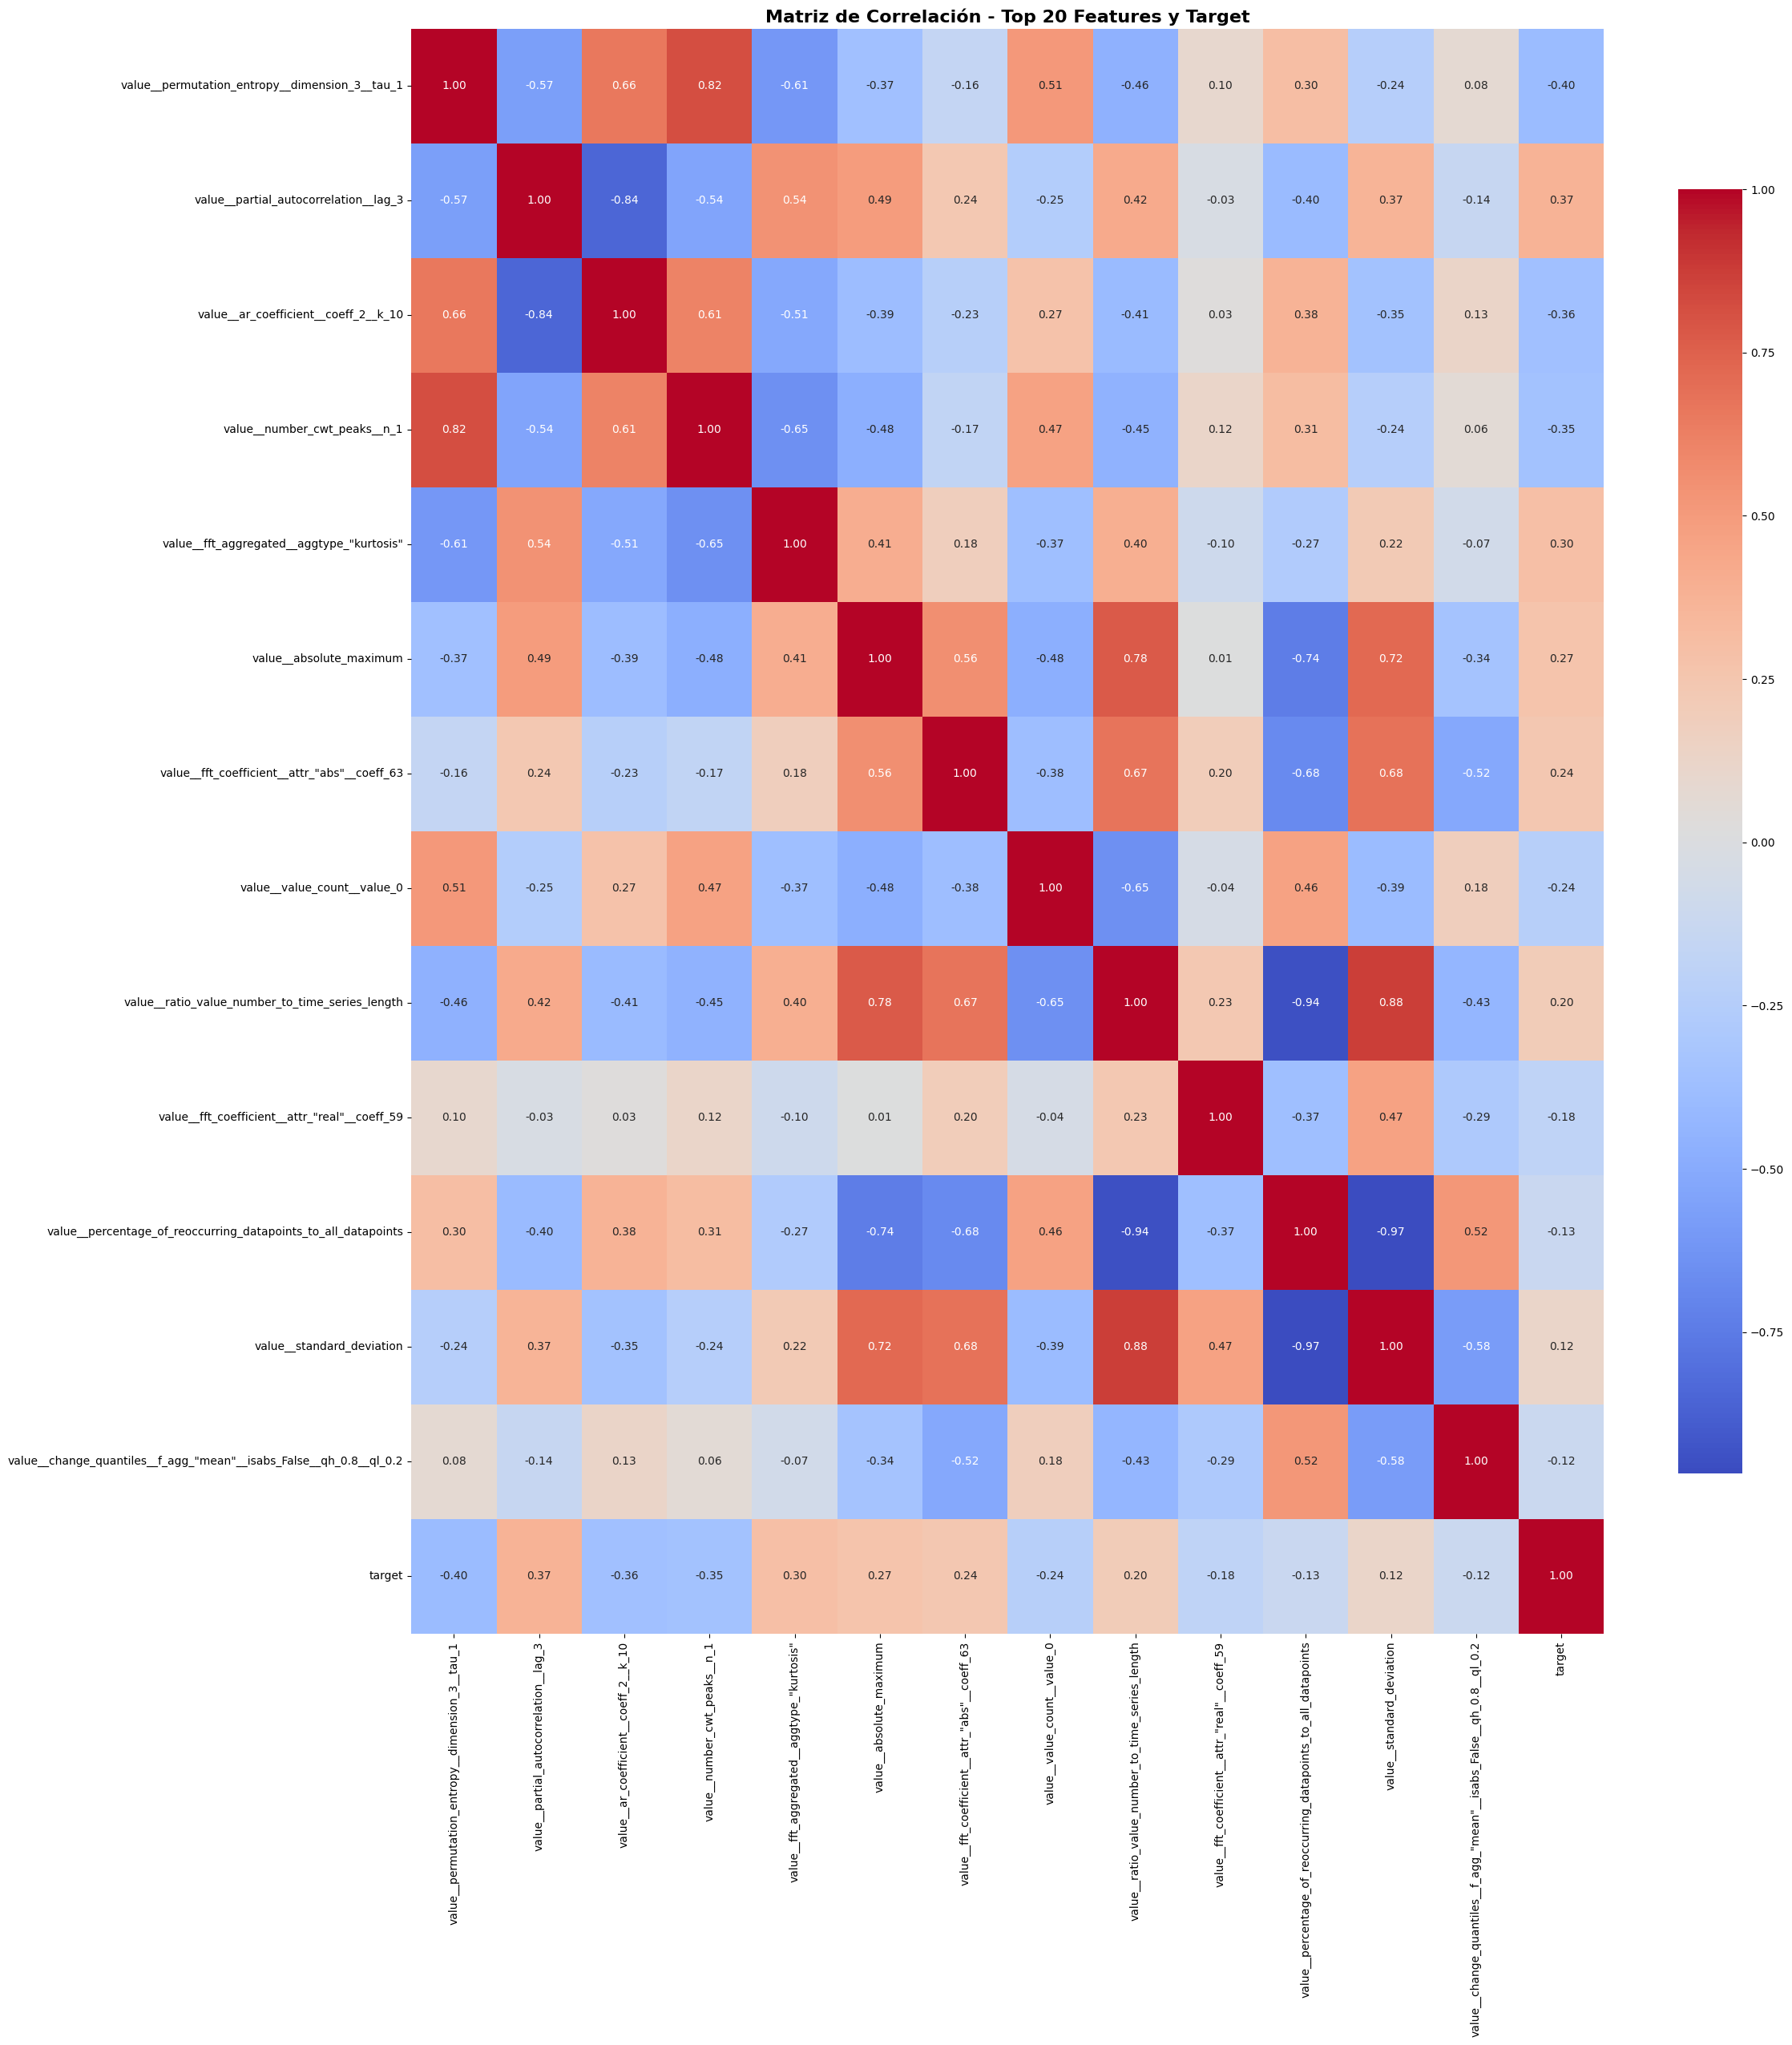

In [ ]:
# Creame una matriz de correlación de las top 13 features y la target con seaborn
corr_matrix_final = x_train_final.corr()
plt.figure(figsize=(24, 26))
sns.heatmap(corr_matrix_final, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={"shrink": .8})
plt.title('Matriz de Correlación - Top 13 Features y Target', fontsize=16, fontweight='bold')
plt.show()

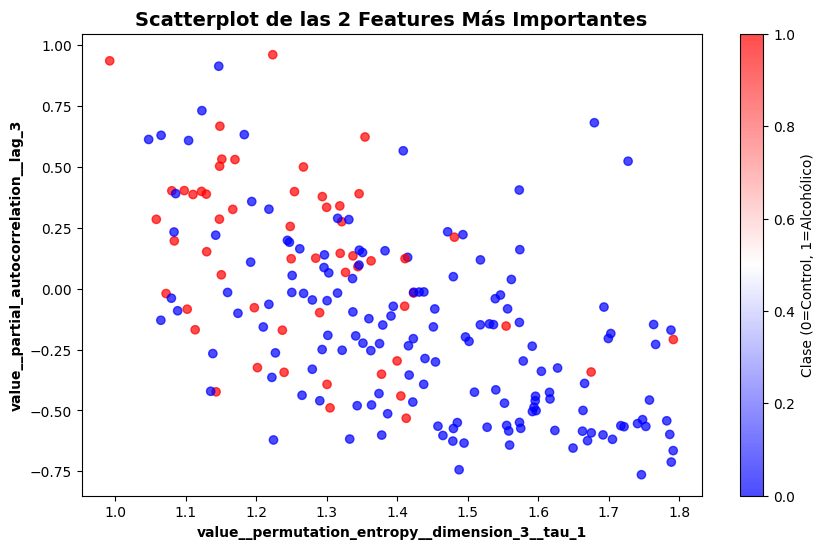

In [160]:
top_features = [
    x_train_final.columns[0],  # la más importante
    x_train_final.columns[1]   # la segunda más importante
]

plt.figure(figsize=(10, 6))
plt.scatter(
    x_train_final[top_features[0]], 
    x_train_final[top_features[1]], 
    c=y_train_series, cmap='bwr', alpha=0.7
)
plt.xlabel(top_features[0], fontweight='bold')
plt.ylabel(top_features[1], fontweight='bold')
plt.title('Scatterplot de las 2 Features Más Importantes', fontsize=14, fontweight='bold')
plt.colorbar(label='Clase (0=Control, 1=Alcohólico)')
plt.show()

In [ ]:
x_train_final.to_csv('../data/final_features/x_train_final.csv', index=False)